
# Analiza jakości powietrza — Kraków, os. Piastów (2016–2025)

To jest **notebook zaliczeniowy** dla kursu z usługi : - Data Science (Python) + wstęp do Machine Learning - Małopolski
Pracujesz na rzeczywistych danych środowiskowych: dzienne **AQI** dla `PM2.5`, `PM10`, `O3`, `NO2`, `SO2`, `CO`.

## Kontekst merytoryczny
- **AQI (Air Quality Index)** to indeks jakości powietrza skalowany tak, aby różne zanieczyszczenia można było porównywać w jednej skali ryzyka zdrowotnego.  
- W tym zbiorze wartości dla każdej substancji to **indywidualne współczynniki AQI** — zostały już przeliczone z surowych stężeń (mg/m³, ppm, ppb) według standardu **EPA**.
- **Złożony AQI** dla dnia definiuje się jako **maksimum** spośród dostępnych indywidualnych wskaźników:  
$$
AQI_{\text{total}} = \max(AQI_{PM2.5}, AQI_{PM10}, AQI_{O3}, AQI_{NO2}, AQI_{SO2}, AQI_{CO})
$$
  Taki wybór odzwierciedla najbardziej dokuczliwy czynnik zdrowotny danego dnia.

## Zakres danych i źródła
- Lokalizacja: **Kraków, os. Piastów, Małopolska, Poland**
- Zakres: **średni dzienny AQI** od **stycznia 2016** do **listopada 2025** (ok. 119 miesięcy)
- Źródła danych:
  - Regional Inspectorate for Environmental Protection in Krakow (WIOŚ Kraków) / Główny Inspektorat Ochrony Środowiska
  - Kanały danych:
    - Historyczne: aqicn.org/historical/#city:poland/malopolska/krakow--os.-piastow
    - Bieżące: aqicn.org/station/poland/malopolska/krakow--os.-piastow




In [41]:
#import potrzebnych blibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
print("Środowisko gotowe — pandas:", pd.__version__)
df=pd.read_csv('data.csv', na_values=[' '])
df.columns = [col.strip() for col in df.columns]
df['date'] = pd.to_datetime(df['date'])


Środowisko gotowe — pandas: 2.3.3



## Zadanie 1 — Wczytanie i pierwszy przegląd danych
**Co zrobisz:** załaduj plik CSV z danymi, spojrz na kilka pierwszych wierszy, sprawdz typy kolumn metoda info,  i to, czy są braki.  
**Po co:** żeby upewnić się, że plik jest poprawny, a daty są interpretowane jako daty.


In [42]:
display(df.head())
display(df.info())
display(df.isnull().sum())

,date,pm25,pm10,o3,no2,so2,co
0,2025-11-01,88.000,25.000,19.000,11.000,1.000,NaN
1,2025-11-02,62.000,18.000,15.000,13.000,NaN,NaN
2,2025-11-03,50.000,26.000,11.000,12.000,1.000,NaN
3,2025-11-04,61.000,39.000,4.000,9.000,1.000,NaN
4,2025-11-05,87.000,41.000,7.000,11.000,1.000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3496 non-null   datetime64[ns]
 1   pm25    2619 non-null   float64       
 2   pm10    3457 non-null   float64       
 3   o3      2586 non-null   float64       
 4   no2     2624 non-null   float64       
 5   so2     2243 non-null   float64       
 6   co      1256 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 191.3 KB


None

date       0
pm25     877
pm10      39
o3       910
no2      872
so2     1253
co      2240
dtype: int64


## Zadanie 2 — Braki danych i przygotowanie do analizy
**Co zrobisz:** zidentyfikuj i uzupełnij brakujące dane w kolumnach z AQI, wybierając podejście, które zachowuje ciągłość w czasie. Zadbaj też, aby nie było wartości ujemnych metodą `clip` : https://pandas.pydata.org/docs/reference/api/pandas.Series.clip.html.  
**Po co:** braki mogą pochodzić z przerw pomiarowych; ich łagodne uzupełnienie umożliwia spójne wykresy i obliczenia.


In [43]:
aqi_cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
df[aqi_cols] = df[aqi_cols].interpolate(method='linear')
df[aqi_cols] = df[aqi_cols].clip(lower=0)
df[aqi_cols] = df[aqi_cols].bfill()
display(df[aqi_cols].isnull().sum())

pm25    0
pm10    0
o3      0
no2     0
so2     0
co      0
dtype: int64


## Zadanie 3 — Statystyki opisowe i przygotowanie pól czasowych
**Co zrobisz:** obliczysz podstawowe statystyki opisowe dla każdej substancji i dodasz kolumny z rokiem oraz miesiącem . Przyklad  dla miesiaca w dokumentacji Pandas: https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html   
**Po co:** aby rozumieć typowe poziomy, zmienność i przygotować się do analiz sezonowości.


In [44]:
display(df[aqi_cols].describe())
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
display(df[['date', 'year', 'month']].head())

,pm25,pm10,o3,no2,so2,co
count,"3,496.000","3,496.000","3,496.000","3,496.000","3,496.000","3,496.000"
mean,50.608,25.923,27.939,9.902,2.196,5.035
std,33.728,15.530,12.127,4.395,1.576,2.316
min,8.000,4.000,1.000,1.000,1.000,1.000
25%,18.000,16.000,19.000,7.000,1.000,4.000
50%,43.000,22.000,31.000,9.000,2.000,4.000
75%,67.000,32.000,37.000,12.020,3.000,6.825
max,197.000,183.000,80.000,38.000,36.000,27.000


,date,year,month
0,2025-11-01,2025,11
1,2025-11-02,2025,11
2,2025-11-03,2025,11
3,2025-11-04,2025,11
4,2025-11-05,2025,11



## Zadanie 4 — Trend czasowy dla PM2.5
**Co zrobisz:** przedstaw na wykresie liniowym, jak zmieniały się wartości PM2.5 w czasie.  Najpierw ustaw `date` jako index

**Po co:** PM2.5 to drobne cząstki szczególnie ważne zdrowotnie; długi horyzont pokazuje trendy i sezonowość.


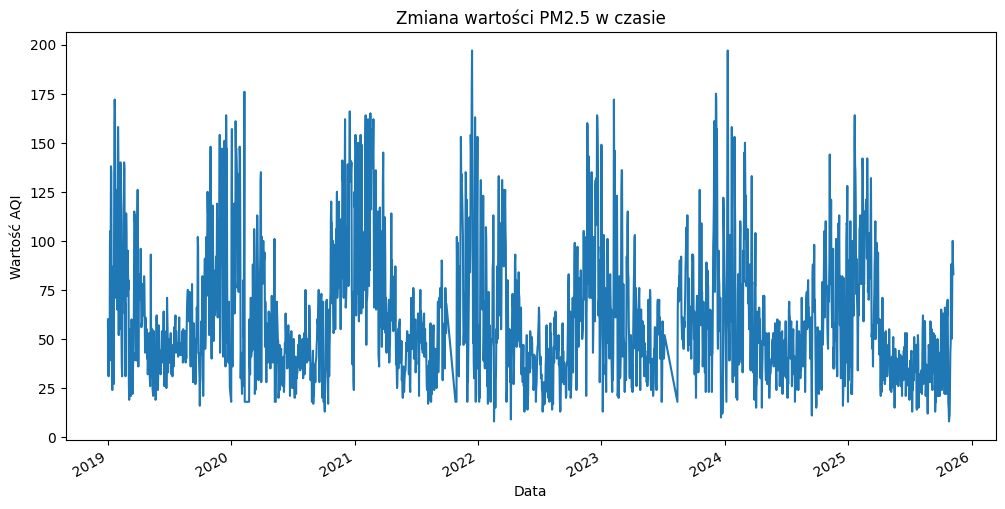

In [45]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.loc['2019-01-01':,'pm25'].plot(figsize=(12, 6))
plt.title('Zmiana wartości PM2.5 w czasie')
plt.ylabel('Wartość AQI')
plt.xlabel('Data')
plt.show()



## Zadanie 5 — Współwystępowanie zanieczyszczeń
**Co zrobisz:** porównaj, które substancje zanieczyszczające mają tendencję do pojawiania się razem i zaprezentujesz to w prosty graficzny sposób.  
**Po co:** wysokie współwystępowanie może sugerować wspólne źródła emisji lub podobne warunki meteorologiczne.


In [52]:
import seaborn as sns

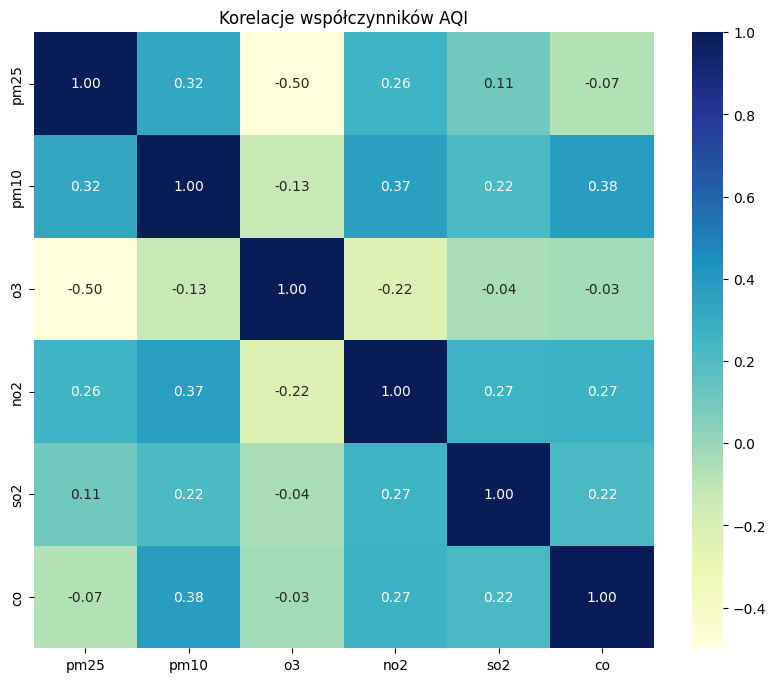

In [70]:
kolumny = df[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(kolumny, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Korelacje współczynników AQI')
plt.show()


## Zadanie 6 — Obliczanie złożonego AQI (wg EPA)
**Co zrobisz:** oblicz ogólny wskaźnik AQI jako  max spośród dostępnych wskaźników dziennych; policz też, ile dni miało pogorszoną jakość powietrza i zobrazuj przebieg w czasie.  
**Po co:** złożony AQI streszcza ryzyko zdrowotne dnia — „najgorszy” składnik decyduje o wyniku.


Liczba wszystkich dni: 3496
Liczba dni z AQI powyżej 100: 357
Udział dni zanieczyszczonych(%): 10.21


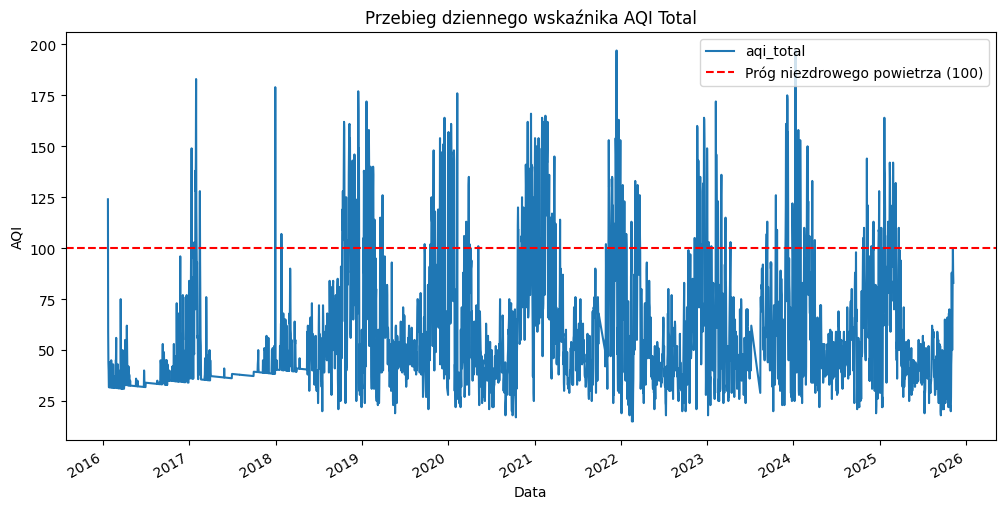

In [61]:
zanieczyszczenia = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
df['aqi_total'] = df[zanieczyszczenia].max(axis=1)
prog = 100
liczba_wszystkich_dni = len(df)
liczba_zlych_dni = (df['aqi_total'] > prog).sum()
procent_zlych = (liczba_zlych_dni / liczba_wszystkich_dni) * 100
print("Liczba wszystkich dni:", liczba_wszystkich_dni)
print("Liczba dni z AQI powyżej 100:", liczba_zlych_dni)
print("Udział dni zanieczyszczonych(%):", procent_zlych.round(2))
plt.figure(figsize=(12, 6))
df['aqi_total'].plot()
plt.axhline(y=prog, color='red', linestyle='--', label='Próg niezdrowego powietrza (100)')
plt.title('Przebieg dziennego wskaźnika AQI Total')
plt.ylabel('AQI')
plt.xlabel("Data")
plt.legend() 
plt.show()


## Zadanie 7 — Sezonowość jakości powietrza
**Co zrobisz:** wyznacz typowy poziom złożonego AQI dla każdego miesiąca w skali wieloletniej i pokaż to na wykresie słupkowym.  Pogrupuj po miesiącu

**Po co:** w naszym klimacie zimą AQI zwykle rośnie (ogrzewanie, inwersje temperatury, mniejsza wentylacja).


Średnia w poszczególnych miesiącach: month
1    75.927
2    67.085
3    65.296
4    51.380
5    41.607
6    43.625
7    42.833
8    46.265
9    49.500
10   57.305
11   74.416
12   77.071
Name: aqi_total, dtype: float64
Średnia ze wszystkich miesięcy: 57.69


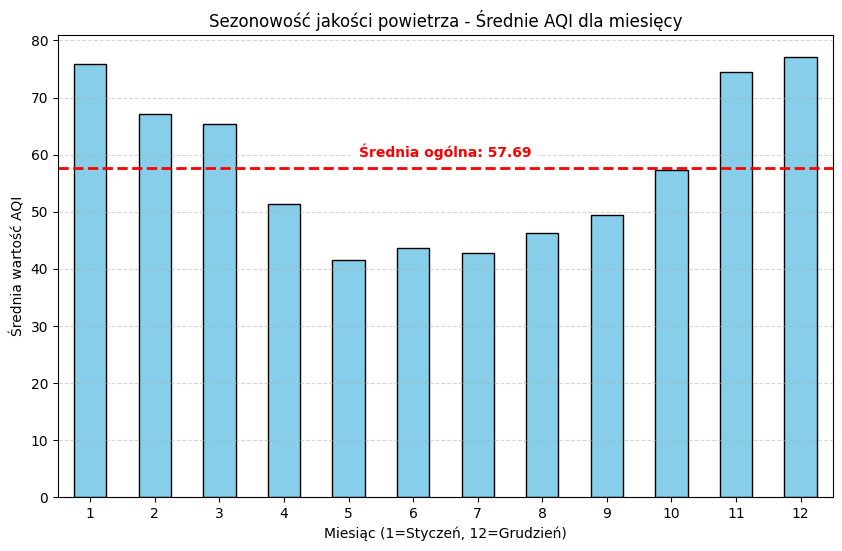

In [83]:
srednie_aqi_miesiace = df.groupby('month')['aqi_total'].mean()
print('Średnia w poszczególnych miesiącach:', srednie_aqi_miesiace)
srednia_ogolna = srednie_aqi_miesiace.mean()
print('Średnia ze wszystkich miesięcy:', srednia_ogolna.round(2))
plt.figure(figsize=(10, 6))
srednie_aqi_miesiace.plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(y=srednia_ogolna, color='red', linestyle='--', linewidth=2,
            label='Średnia roczna (' + str(round(srednia_ogolna, 2)) + ')')
plt.text(x=5.5, 
         y=srednia_ogolna + 2, 
         s='Średnia ogólna: ' + str(round(srednia_ogolna, 2)), 
         color='red', 
         fontweight='bold',
         ha='center',
         backgroundcolor='white')
plt.title('Sezonowość jakości powietrza - Średnie AQI dla miesięcy')
plt.xlabel('Miesiąc (1=Styczeń, 12=Grudzień)')
plt.ylabel('Średnia wartość AQI')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


## Zadanie 8 *  — Wygładzanie trendu (średnia krocząca) - ZADANIE DODATKOWE
**Co zrobisz:** wygładz dzienny przebieg złożonego AQI w horyzoncie około miesiąca i porównaj go z przebiegiem pełnym.  - uzyj metody .rolling - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

**Po co:** ułatwia to dostrzeżenie trwałych zmian, eliminując codzienny szum.


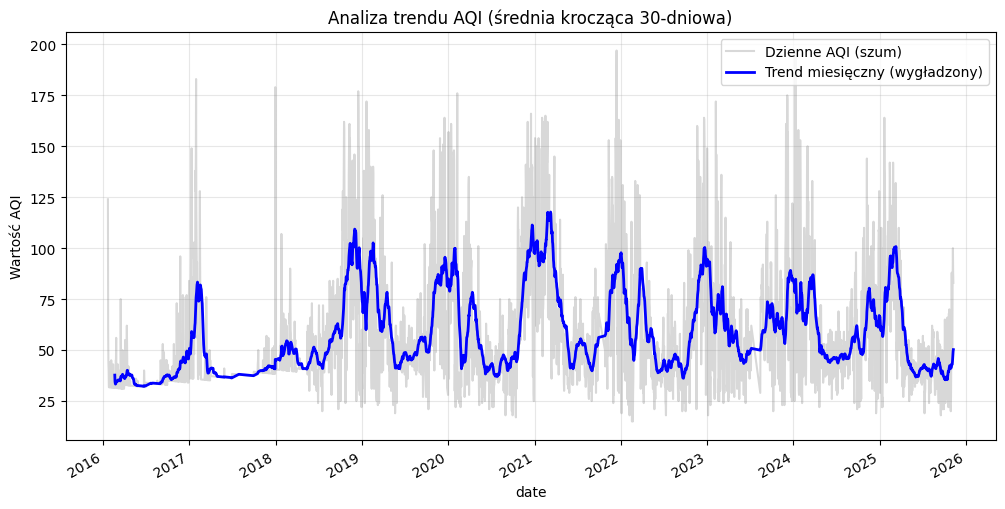

In [86]:
okno = 30
df['aqi_smoothed'] = df['aqi_total'].rolling(window=okno).mean()
plt.figure(figsize=(12, 6))
df['aqi_total'].plot(color='gray', alpha=0.3, label='Dzienne AQI (szum)')
df['aqi_smoothed'].plot(color='blue', linewidth=2, label='Trend miesięczny (wygładzony)')
plt.title('Analiza trendu AQI (średnia krocząca ' + str(okno) + '-dniowa)')
plt.ylabel('Wartość AQI')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Zadanie 9 — Kategorie jakości powietrza (EPA) - ZADANIE DODATKOWE
**Co zrobisz:** zaklasyfikuj dni do kategorii jakości powietrza według popularnej skali (np. dobra, umiarkowana, niezdrowa dla wrażliwych itd.) i pokaż rozkład tych kategorii.  
**Po co:** kategorie są praktyczne w komunikacji ryzyka dla mieszkańców.


Liczba dni w poszczególnych kategoriach:
kategoria_aqi
Dobra               1940
Umiarkowana         1199
Dla wrażliwych       305
Niezdrowa             52
Bardzo niezdrowa       0
Niebezpieczna          0
Name: count, dtype: int64


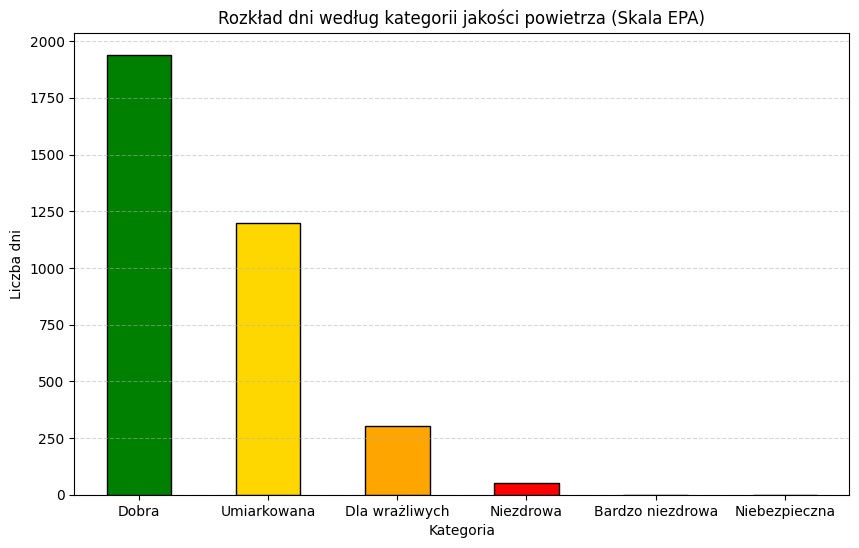

In [87]:
przedzialy = [-1, 50, 100, 150, 200, 300, 5000]
nazwy = ['Dobra', 'Umiarkowana', 'Dla wrażliwych', 'Niezdrowa', 'Bardzo niezdrowa', 'Niebezpieczna']
df['kategoria_aqi'] = pd.cut(df['aqi_total'], bins=przedzialy, labels=nazwy)
licznik_kategorii = df['kategoria_aqi'].value_counts().sort_index()
print("Liczba dni w poszczególnych kategoriach:")
print(licznik_kategorii)
plt.figure(figsize=(10, 6))
kolory_epa = ['green', 'gold', 'orange', 'red', 'purple', 'brown']
licznik_kategorii.plot(kind='bar', color=kolory_epa, edgecolor='black')
plt.title('Rozkład dni według kategorii jakości powietrza (Skala EPA)')
plt.ylabel('Liczba dni')
plt.xlabel('Kategoria')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


## Zadanie 10 — Wnioski końcowe
**Co zrobisz:** sformułujesz krótką interpretację wyników — kiedy jakość powietrza była najgorsza,
które substancje najczęściej dominowały w złożonym AQI oraz jaką sezonowość widać w danych.  
**Po co:** wnioski łączą wyniki obliczeń z praktycznym zrozumieniem zjawiska.


_Wpisz tutaj swoje wnioski…_

In [93]:
print("--- Wnioski końcowe ---")

print("1. Kiedy jakość powietrza jest najgorsza?")
print("   Analiza wykresów (zwłaszcza średnich miesięcznych) pokazuje, że najgorsze powietrze mamy zimą.")
print("   Miesiące takie jak styczeń, luty i grudzień mają najwyższe słupki AQI i są powyżej średniej wszystkich miesięcy")

print("\n2. Co dominuje w zanieczyszczeniach?")
print("   Najwyższe wartości osiąga zazwyczaj PM2.5.")
print("   Jego skoki pokrywają się z zimowym sezonem, co sugeruje wpływ ogrzewania domów.")

print("\n3. Czy widać sezonowość?")
print("   Tak, sezonowość jest bardzo wyraźna.")
print("   W miesiącach letnich jakość powietrza jest stabilna i dobra, natomiast zimą gwałtownie się pogarsza.")

print("\n4. Podsumowanie ryzyka")
print("   Mimo że średnie wartości często wyglądają nieźle, analiza wykresu dziennego pokazuje,")
print("   że zdarzają się dni z AQI powyżej 100, które są niezdrowe dla wrażliwych grup.")

--- Wnioski końcowe ---
1. Kiedy jakość powietrza jest najgorsza?
   Analiza wykresów (zwłaszcza średnich miesięcznych) pokazuje, że najgorsze powietrze mamy zimą.
   Miesiące takie jak styczeń, luty i grudzień mają najwyższe słupki AQI i są powyżej średniej wszystkich miesięcy

2. Co dominuje w zanieczyszczeniach?
   Najwyższe wartości osiąga zazwyczaj PM2.5.
   Jego skoki pokrywają się z zimowym sezonem, co sugeruje wpływ ogrzewania domów.

3. Czy widać sezonowość?
   Tak, sezonowość jest bardzo wyraźna.
   W miesiącach letnich jakość powietrza jest stabilna i dobra, natomiast zimą gwałtownie się pogarsza.

4. Podsumowanie ryzyka
   Mimo że średnie wartości często wyglądają nieźle, analiza wykresu dziennego pokazuje,
   że zdarzają się dni z AQI powyżej 100, które są niezdrowe dla wrażliwych grup.
